# Convolutional neural network

You tested above different models with the set of high-level features extracted from a
pretrained neural network. However, can you get similar results by creating a ConvNet
from scratch and using the pixel values from the original images to train the model?
- What accuracy can you achieve?
- Can you get good results? - If not, why?


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
train_generator = ImageDataGenerator(
    rescale=1/255, horizontal_flip=True, rotation_range=5)

valid_generator = ImageDataGenerator(rescale=1/255)

test_generator = ImageDataGenerator(rescale=1/255)

In [3]:
trainset = train_generator.flow_from_directory(
     'train', batch_size=32, target_size=(224, 224),
    shuffle=True, class_mode = 'sparse')
validset = valid_generator.flow_from_directory(
    'valid', batch_size=32, target_size=(224, 224),
    shuffle=False, class_mode = 'sparse')
testset = test_generator.flow_from_directory(
    'test', batch_size=32, target_size=(224, 224),
    shuffle=False, class_mode = 'sparse')

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [4]:
trainset.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [5]:
batch_imgs, batch_labels = trainset.next() # 32 images per batch

print('Batch images:', batch_imgs.shape) 
print('Batch labels:', batch_labels.shape)

Batch images: (32, 224, 224, 3)
Batch labels: (32,)


In [6]:
# Convolutional Network
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,
                              activation='relu', input_shape=(224, 224, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 259590    
Total params: 301,382
Trainable params: 301,382
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [8]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) 

# Train model
history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
9/9 [==============================] - 9s 1s/step - loss: 1.8771 - acc: 0.2301 - val_loss: 1.7684 - val_acc: 0.2302
Epoch 2/100
9/9 [==============================] - 8s 935ms/step - loss: 1.7092 - acc: 0.3141 - val_loss: 1.6703 - val_acc: 0.2734
Epoch 3/100
9/9 [==============================] - 8s 900ms/step - loss: 1.5941 - acc: 0.3614 - val_loss: 1.5570 - val_acc: 0.3885
Epoch 4/100
9/9 [==============================] - 8s 869ms/step - loss: 1.4212 - acc: 0.4930 - val_loss: 1.4408 - val_acc: 0.4317
Epoch 5/100
9/9 [==============================] - 8s 891ms/step - loss: 1.2476 - acc: 0.5164 - val_loss: 1.2996 - val_acc: 0.5180
Epoch 6/100
9/9 [==============================] - 14s 2s/step - loss: 1.0127 - acc: 0.6818 - val_loss: 1.3312 - val_acc: 0.4820
Epoch 7/100
9/9 [==============================] - 13s 1s/step - loss: 0.8582 - acc: 0.6884 - val_loss: 1.4850 - val_acc: 0.4604
Epoch 8/100
9/9 [==============================] - 12s 1s/step - loss: 0.7104 - acc: 0.735

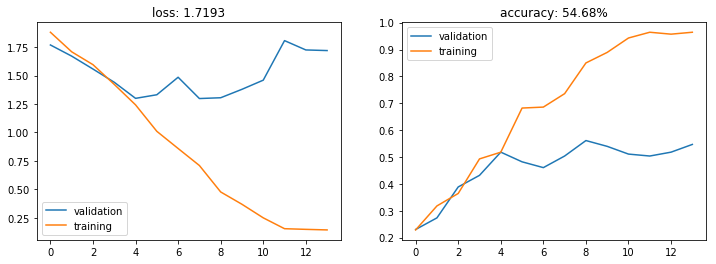

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [10]:
test_preds = model.predict_generator(testset)
print('Predictions:', test_preds.shape)

Predictions: (50, 6)


In [11]:
matrix = confusion_matrix(
    y_true=testset.classes, # array with true labels
    y_pred=test_preds.argmax(axis=1)) # array with predicted labels

In [12]:
matrix

array([[9, 0, 3, 0, 0, 0],
       [2, 5, 2, 0, 1, 1],
       [1, 4, 4, 0, 0, 0],
       [1, 1, 3, 0, 1, 0],
       [0, 4, 1, 0, 1, 1],
       [0, 2, 1, 0, 0, 2]], dtype=int64)

In [13]:
# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = 'Predictions'
matrix_df.index.name = 'True class'
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,9,0,3,0,0,0
car,2,5,2,0,1,1
motorcycle,1,4,4,0,0,0
other,1,1,3,0,1,0
truck,0,4,1,0,1,1
van,0,2,1,0,0,2


In [17]:
valid_loss, valid_acurracy = model.evaluate_generator(validset)
print('Valid loss: {:.2f}, Valid accuracy: {:.2f}%'.format(valid_loss, valid_acurracy*100))

Valid loss: 1.72, Valid accuracy: 54.68%


**Findings:** Let's evaluate the evaluation accuarcy of 54,7% from ConvNet model with the previously pre-trained models based on the high level features from MovileNet v2:

- k-NN: 44,6% 
- Simple decision tree: 30,2% 
- LogRegression: 39,1% 
- Random Forest: 19,4% 
- RBF SVM: 23,7% 
- 1-layer NN: 21,3% 
- 2-layer NN: 21,3% 

The ConvNet gets significantly better results than all previous models according to the test validation accuracy.

-------

Store the model name and the accuracy on the test data in a .csv file:

In [18]:
test_loss, test_acurracy = model.evaluate_generator(testset)
print('Test loss: {:.2f}, Test accuracy: {:.2f}%'.format(test_loss, test_acurracy*100))

Test loss: 1.95, Test accuracy: 42.00%


In [35]:
Test_accuracy_08_Convnets =  pd.DataFrame(data = {'model': ['cnn'], 'test_acurracy': [test_acurracy]})

In [52]:
Test_accuracy_08_Convnets.to_csv(path_or_buf = r'C:\Users\heyus\Desktop\Desktop\EPFL_Data Science COS\EPFL\04. Applied Machine Learning 2\11. Course project\Test_accuracy_08_Convnets.csv')